In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.under_sampling import RandomUnderSampler
import re
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/verityData/verityF2 new Gdata.csv')
data.head()

,tweet,mentions,hashtags,ORG_percentage,PERSON_percentage,BotScoreBinary
0,Arm without sell sister reach so film force li...,0.0,0.0,0.000000,0.0,1.0
1,Huge around consumer identify bill be business...,0.0,0.0,7.142857,0.0,1.0
2,Suffer shoulder person notice save.,0.0,0.0,0.000000,0.0,1.0
3,Often court because edge between official agen...,0.0,0.0,0.000000,0.0,1.0
4,Home through say beyond computer as require in...,0.0,0.0,0.000000,0.0,1.0


In [ ]:
data.tail()

,tweet,mentions,hashtags,ORG_percentage,PERSON_percentage,BotScoreBinary
234198,Joe Biden's family owned African slaves....\n\...,0.0,0.0,1.000000,0.0,0.0
234199,"Joe Bidens great, great grandfather was a slav...",0.0,0.0,0.500000,0.5,0.0
234200,"@ChevyChaseToGo ""Joe Bidens great-grandfather ...",1.0,0.0,0.000000,0.0,0.0
234201,@JoeBiden Facts are Bidens VP Kamala Harris Gr...,1.0,0.0,0.000000,0.0,0.0
234202,@sunny Yes representation matters. Did you kno...,1.0,0.0,0.333333,0.0,0.0


In [ ]:
data.columns

Index(['tweet', 'mentions', 'hashtags', 'ORG_percentage', 'PERSON_percentage',
       'BotScoreBinary'],
      dtype='object')

In [ ]:
# Drop rows with NaN values
data = data.dropna()

In [ ]:
# Prepare tweet data for model
max_words = 1000  # Max number of words to keep in Tokenizer
max_seq_length = 100  # Max sequence length for padding

In [ ]:
data["BotScoreBinary"].value_counts()

,count
BotScoreBinary,
0.0,129856
1.0,104342


In [ ]:
# Separate the features (X) and target (y)
x = data.drop(columns=["BotScoreBinary"])  # Drop the target column
y = data["BotScoreBinary"]  # Target column

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

data['tweet'] = data['tweet'].apply(clean_text)

In [ ]:
# Preprocess text data (same as before)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x['tweet'])
sequences_balanced = tokenizer.texts_to_sequences(x['tweet'])
x_text_balanced = pad_sequences(sequences_balanced, maxlen=max_seq_length)

In [ ]:
scaler = StandardScaler()

In [ ]:
numeric_features = [
    'mentions',
    'hashtags',
    'ORG_percentage',
    'PERSON_percentage'
]

In [ ]:
# Scale numeric features (same as before)
x_numeric_balanced = data[numeric_features].values
x_numeric_balanced_scaled = scaler.fit_transform(x_numeric_balanced)

In [ ]:
# Split balanced data into training and testing sets
x_train_text, x_test_text, x_train_numeric, x_test_numeric, y_train, y_test = train_test_split(
    x_text_balanced, x_numeric_balanced_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Define model parameters
embedding_dim = 128
lstm_units = 64
dense_units = 64
dropout_rate = 0.2
l2_lambda = 0.01
max_seq_length = 100
max_words = 1000
num_numeric_features = 4

In [ ]:
# Define text input (tweets)
text_input = Input(shape=(max_seq_length,), name='text_input')
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_length)(text_input)
lstm_layer = LSTM(units=lstm_units, return_sequences=False)(embedding_layer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Define numeric input (other features)
numeric_input = Input(shape=(num_numeric_features,), name='numeric_input')
dense_layer_numeric = Dense(units=dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(numeric_input)


In [ ]:
# Combine LSTM output and numeric features
combined = concatenate([lstm_layer, dense_layer_numeric])

# Add additional dense layers
dense_combined = Dense(units=dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(combined)
dropout_combined = Dropout(rate=dropout_rate)(dense_combined)

# Add more dense layers for a deeper model
dense_combined_2 = Dense(units=dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(dropout_combined)
batch_norm_combined_2 = BatchNormalization()(dense_combined_2)
dropout_combined_2 = Dropout(rate=dropout_rate)(batch_norm_combined_2)

# Add another dense layer for further abstraction
dense_combined_3 = Dense(units=dense_units // 2, activation='relu', kernel_regularizer=l2(l2_lambda))(dropout_combined_2)
batch_norm_combined_3 = BatchNormalization()(dense_combined_3)
dropout_combined_3 = Dropout(rate=dropout_rate)(batch_norm_combined_3)

# Output layer for binary classification
output = Dense(units=1, activation='sigmoid')(dropout_combined)

In [ ]:
# Define the model
model = Model(inputs=[text_input, numeric_input], outputs=output)


In [ ]:
from tensorflow.keras.optimizers import AdamW
model.compile(optimizer=AdamW(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 100, 128)       │        128,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_input             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 64)             │         49,408 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │            320 │ numeric_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 128)            │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 64)             │          8,256 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64)             │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 1)              │             65 │ dropout_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 186,049 (726.75 KB)

 Trainable params: 186,049 (726.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    [x_train_text, x_train_numeric],
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 394s 166ms/step - accuracy: 0.9122 - loss: 0.7754 - val_accuracy: 0.9769 - val_loss: 0.1300
Epoch 2/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 404s 172ms/step - accuracy: 0.9780 - loss: 0.1163 - val_accuracy: 0.9783 - val_loss: 0.0974
Epoch 3/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 386s 165ms/step - accuracy: 0.9786 - loss: 0.0981 - val_accuracy: 0.9785 - val_loss: 0.0934
Epoch 4/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 385s 165ms/step - accuracy: 0.9794 - loss: 0.0926 - val_accuracy: 0.9787 - val_loss: 0.0921
Epoch 5/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 459s 172ms/step - accuracy: 0.9785 - loss: 0.0943 - val_accuracy: 0.9792 - val_loss: 0.0894
Epoch 6/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 398s 170ms/step - accuracy: 0.9798 - loss: 0.0894 - val_accuracy: 0.9794 - val_loss: 0.0886
Epoch 7/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 428s 164ms/step - accuracy: 0.9795 - loss: 0.0900 - val_accuracy: 0.9793 - val_loss: 0.0883
Epoch 8/50
2342/2342 ━━━━━━━━━━━━━━━━━━━━ 382s 163ms/step - ac

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate([x_test_text, x_test_numeric], y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

1464/1464 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.9784 - loss: 0.0886
Test Accuracy: 0.9792


In [ ]:
train_loss, train_accuracy = model.evaluate([x_train_text, x_train_numeric], y_train)
print(f"train Accuracy: {train_accuracy:.4f}")

5855/5855 ━━━━━━━━━━━━━━━━━━━━ 144s 25ms/step - accuracy: 0.9802 - loss: 0.0795
train Accuracy: 0.9805


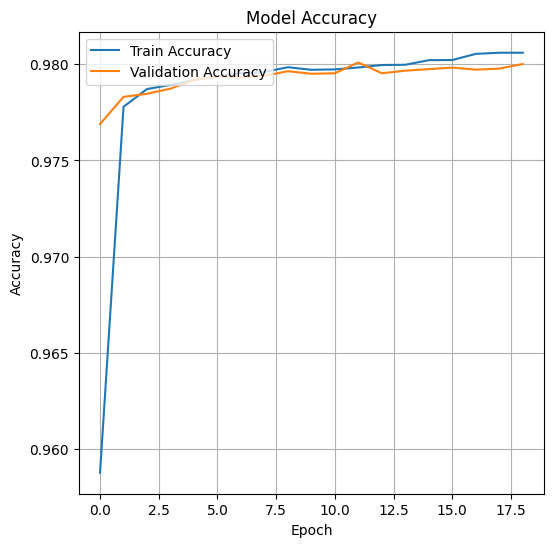

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

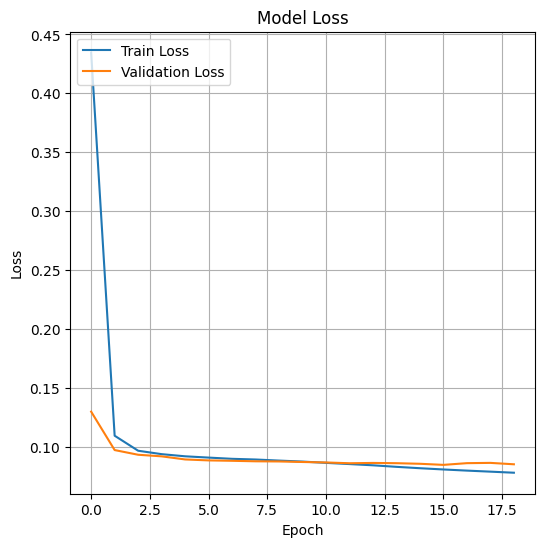

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Predict on test set
y_pred = model.predict([x_test_text, x_test_numeric])
y_pred_classes = (y_pred > 0.5).astype(int)

1464/1464 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step


In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[26147    71]
 [  902 19720]]


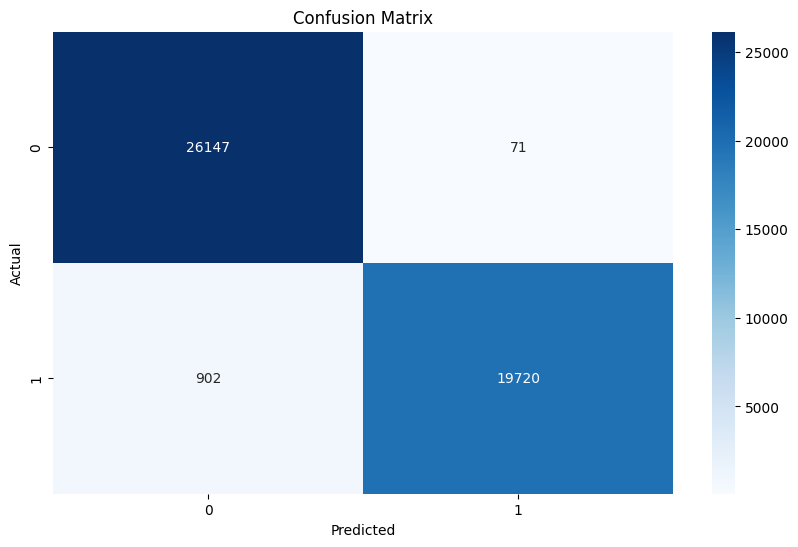

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('twitter_bot_detection_model.h5')


Retraining


In [ ]:
custom_data  = pd.read_csv('/content/drive/MyDrive/Dataset/updated_tweets.csv')
custom_data .head()

,date,text,link,likes,retweets,comments,user_name,user_username,user_avatar,label,...,word_count,adjectives,adverbs,pronouns,capitals,digits,hashtags,URLs,ORG_percentage,PERSON_percentage
0,"Jan 9, 2021 · 12:41 PM UTC",ඔබට ඔබගේ #hashtag #retweet කරගැනීමට අවශ්‍ය නම්...,https://twitter.com/SLRTBot/status/13478862284...,97,34,21,SL RT Bot 🇱🇰🤖,@SLRTBot,https://pbs.twimg.com/profile_images/134775335...,1,...,9,1,0,0,3,0,3,0,0.0,0.0
1,"Jun 13, 2023 · 3:54 PM UTC",she made breakfast! anyone want some? #tasty...,https://twitter.com/CutestGraham/status/166864...,10,2,2,𝐴𝑠ℎ𝑙𝑒𝑦 𝐺𝑟𝑎ℎ𝑎𝑚,@CutestGraham,https://pbs.twimg.com/profile_images/164524557...,1,...,7,0,0,1,0,0,1,0,0.0,0.0
2,"Jun 13, 2023 · 4:02 PM UTC",It's #TastyTuesday and this chocolate hazelnut...,https://twitter.com/FoodlinkNY/status/16686500...,2,1,0,Foodlink,@FoodlinkNY,https://pbs.twimg.com/profile_images/133896538...,1,...,29,4,1,1,10,0,4,0,20.0,20.0
3,"Jun 13, 2023 · 4:02 PM UTC",This #TastyTuesday just got tastier! Enjoy a m...,https://twitter.com/SnarfHappens/status/166865...,2,1,0,Snarf's Sandwiches,@SnarfHappens,https://pbs.twimg.com/profile_images/131679554...,1,...,20,3,1,0,8,0,2,0,50.0,50.0
4,"Jun 13, 2023 · 5:43 PM UTC",Change your lunch plans and come have cold dri...,https://twitter.com/Hotshots_Bar/status/166867...,0,1,0,Hotshots Sports Bar and Grill,@Hotshots_Bar,https://pbs.twimg.com/profile_images/170216292...,1,...,16,0,0,1,6,0,2,0,20.0,40.0


In [ ]:
column_names = custom_data .columns
print(column_names)

Index(['date', 'text', 'link', 'likes', 'retweets', 'comments', 'user_name',
       'user_username', 'user_avatar', 'label', 'mentions', 'word_count',
       'adjectives', 'adverbs', 'pronouns', 'capitals', 'digits', 'hashtags',
       'URLs', 'ORG_percentage', 'PERSON_percentage'],
      dtype='object')


In [ ]:
custom_data["label"].value_counts()

,count
label,
0,200
1,100


In [ ]:
# Ensure 'text' column contains strings
custom_data['text'] = custom_data['text'].astype(str)

# Replace NaN or missing values with empty strings
custom_data['text'] = custom_data['text'].fillna('')

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

custom_data['text'] = custom_data['text'].apply(clean_text)

In [ ]:
x_balanced1 = custom_data.drop(columns=['label'])
y_balanced1 = custom_data['label']

In [ ]:
# Preprocess text data (same as before)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(custom_data['text'])
sequences_balanced1 = tokenizer.texts_to_sequences(x_balanced1['text'])
x_text_balanced1 = pad_sequences(sequences_balanced1, maxlen=max_seq_length)

In [ ]:
numeric_features1 = [
    'mentions',
    'hashtags',
    'ORG_percentage',
    'PERSON_percentage'
]

In [ ]:
# Scale numeric features (same as before)
x_numeric_balanced1 = custom_data[numeric_features1].values
x_numeric_balanced_scaled1 = scaler.fit_transform(x_numeric_balanced1)

In [ ]:
# Split balanced data into training and testing sets
x_train_text1, x_test_text1, x_train_numeric1, x_test_numeric1, y_train1, y_test1 = train_test_split(
    x_text_balanced1, x_numeric_balanced_scaled1, y_balanced1, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model2 = load_model('/content/twitter_bot_detection_model.h5')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model (ensure it uses the same configuration as before)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change to a less suitable loss function


In [ ]:
callbacks = [EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]

In [ ]:
# Train the model
history = model2.fit(
    [x_train_text1, x_train_numeric1],
    y_train1,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6497 - loss: 1.0565 - val_accuracy: 0.7500 - val_loss: 0.6593
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7923 - loss: 0.5470 - val_accuracy: 0.7083 - val_loss: 0.5871
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7995 - loss: 0.4911 - val_accuracy: 0.7083 - val_loss: 0.5606
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8646 - loss: 0.3817 - val_accuracy: 0.7708 - val_loss: 0.5310
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8229 - loss: 0.3315 - val_accuracy: 0.7708 - val_loss: 0.5487
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8405 - loss: 0.3253 - val_accuracy: 0.7500 - val_loss: 0.5069
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8581 - loss: 0.3512 - val_accuracy: 0.6667 - val_loss: 0.7076
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.8229 - loss: 0.3818 - val_accuracy: 0.7917 - val_loss:

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate([x_test_text1, x_test_numeric1], y_test1)
print(f"Test Accuracy: {test_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8917 - loss: 0.3245
Test Accuracy: 0.9000


In [ ]:
train_loss, train_accuracy = model2.evaluate([x_train_text1, x_train_numeric1], y_train1)
print(f"train Accuracy: {train_accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8863 - loss: 0.3071
train Accuracy: 0.8833


In [ ]:
# Predict on test set
y_pred1 = model2.predict([x_test_text1, x_test_numeric1])
y_pred_classes1 = (y_pred1 > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


In [ ]:
# Confusion matrix
cm1 = confusion_matrix(y_test1, y_pred_classes1)
print(cm1)

[[34  4]
 [ 2 20]]


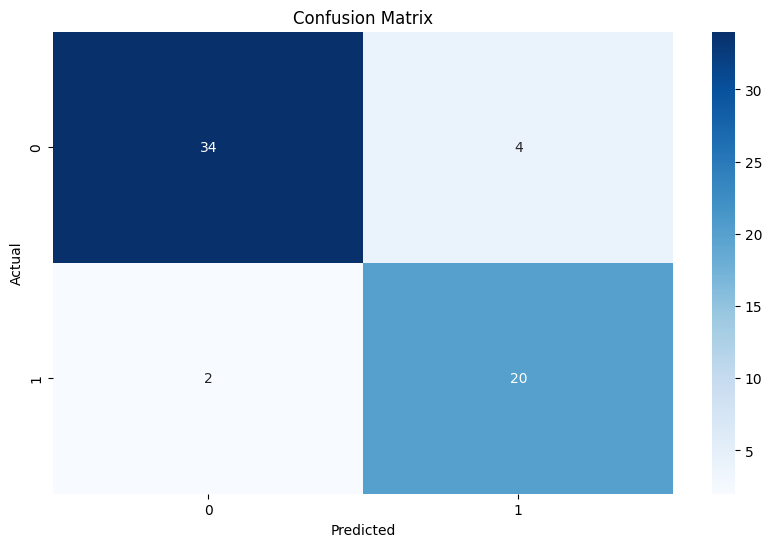

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib
# Save the scaler to a file
scaler_filename = "function2_scaler.pkl"
joblib.dump(scaler, scaler_filename)

['function2_scaler.pkl']

In [ ]:
import pickle
with open('function2_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
# Save the retrained model to a new file
model2.save('twitter_bot_detection_model_retrained.h5')


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Load the retrained model
model3 = load_model('/content/twitter_bot_detection_model_retrained.h5')

# Load the tokenizer
with open('/content/drive/MyDrive/twitter/function2_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


In [ ]:
example_text = [ "The Battle of the Bots concludes with Ranil Wickremesinghe as the clear winner, while Sajith Premadasa comes in second.According to our estimates, based on sudden increases in the vote tallies of certain candidates, at least 60% of responses were from bots."]
example_numeric_data = [[ 2, 1, 0.1, 0.2]]  # Example numeric data matching the features used during training


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

# Preprocess the text data
sequences = tokenizer.texts_to_sequences(example_text)
x_text_example = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as used during training

# Scale the numeric data
scaler = MinMaxScaler()
x_numeric_example = scaler.fit_transform(example_numeric_data)  # You might want to fit the scaler on training data instead

# Combine the preprocessed text and numeric data
input_data = [x_text_example, x_numeric_example]


In [ ]:
# Get predictions
predictions = model3.predict(input_data)

# Convert probabilities to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Output the prediction
print(f"Predicted class: {predicted_classes[0][0]} (0: Not a bot, 1: Bot)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Predicted class: 0 (0: Not a bot, 1: Bot)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(predictions)

[[0.34651464]]


**Testing the model**

In [ ]:
import re
import spacy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load spaCy model for NER (named entity recognition)
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Example input
example_text = ["Scientists warn that [false claim] could be dangerous! 😨 Find out how to protect yourself: [link] #Health #Safety"]


In [ ]:


# Extract features from text
def extract_numeric_features(text):
    # Count mentions (e.g., @username)
    mentions = len(re.findall(r"@\w+", text))

    # Count hashtags (e.g., #hashtag)
    hashtags = len(re.findall(r"#\w+", text))

    # Perform Named Entity Recognition (NER) using spaCy
    doc = nlp(text)

    # Count the number of ORG and PERSON entities
    org_count = len([ent for ent in doc.ents if ent.label_ == "ORG"])
    person_count = len([ent for ent in doc.ents if ent.label_ == "PERSON"])

    # Calculate the total number of named entities for percentages
    total_entities = len(doc.ents) if len(doc.ents) > 0 else 1  # Avoid division by zero

    # Calculate percentage of ORG and PERSON entities
    org_percentage = org_count / total_entities
    person_percentage = person_count / total_entities

    return [mentions, hashtags, org_percentage, person_percentage]

In [ ]:
# Apply the feature extraction to the example text
extracted_numeric_features = extract_numeric_features(example_text[0])


In [ ]:
# Example numeric data (after feature extraction)
example_numeric_data = [extracted_numeric_features]  # [[mentions, hashtags, ORG_percentage, PERSON_percentage]]


In [ ]:
# Preprocess the text data (assuming you have the tokenizer)
sequences = tokenizer.texts_to_sequences(example_text)
x_text_example = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as used during training


In [ ]:
x_numeric_example = scaler.fit_transform(example_numeric_data)  # Fit on training data in actual implementation


In [ ]:
# Combine the preprocessed text and numeric data for prediction
input_data = [x_text_example, x_numeric_example]


In [ ]:
# Get predictions from the model
predictions = model3.predict(input_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
predictions

array([[0.11397568]], dtype=float32)

In [ ]:
# Convert probabilities to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Output the prediction
print(f"Predicted class: {predicted_classes[0][0]} (0: Not a bot, 1: Bot)")

Predicted class: 0 (0: Not a bot, 1: Bot)
